C:\Users\21118\AppData\Local\Temp\ipykernel_15640\4194103676.py:13: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  metabric_df = pd.read_csv("Downloads/METABRIC_RNA_Mutation.csv")


Dataset shape: (1904, 693)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 503 entries, patient_id to ugt2b7
dtypes: float64(498), int64(5)
memory usage: 7.3 MB
None
   patient_id  age_at_diagnosis type_of_breast_surgery    cancer_type
0           0             75.65             MASTECTOMY  Breast Cancer
1           2             43.19      BREAST CONSERVING  Breast Cancer
2           5             48.87             MASTECTOMY  Breast Cancer
3           6             47.68             MASTECTOMY  Breast Cancer
4           8             76.97             MASTECTOMY  Breast Cancer

=== Random Forest ===
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.81      0.73       343
           1       0.58      0.40      0.47       229

    accuracy                           0.64       572
   macro avg       0.62      0.60      0.60       572
weighted avg       0.63      0.64      0.63       572

Accur

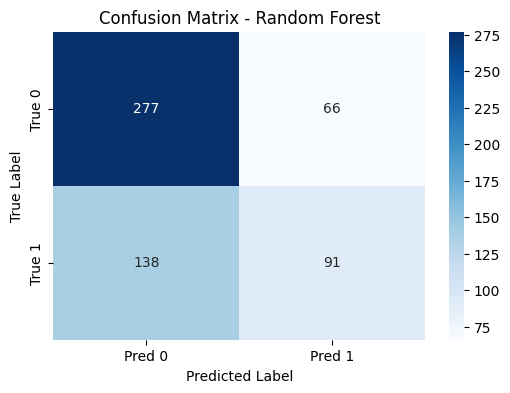

AUC-ROC Score: 0.6618

=== Support Vector Classifier ===
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.79      0.73       343
           1       0.59      0.45      0.51       229

    accuracy                           0.66       572
   macro avg       0.64      0.62      0.62       572
weighted avg       0.65      0.66      0.65       572

Accuracy: 0.6556
F1 Score: 0.6454


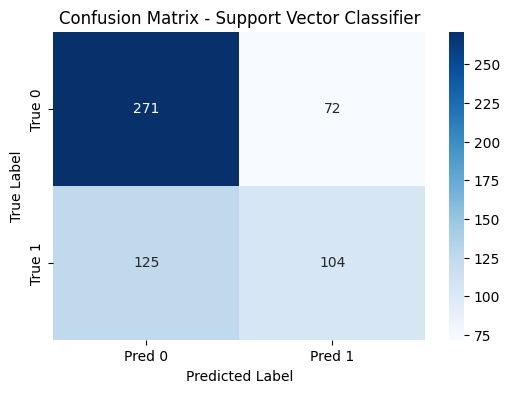

AUC-ROC Score: 0.6740


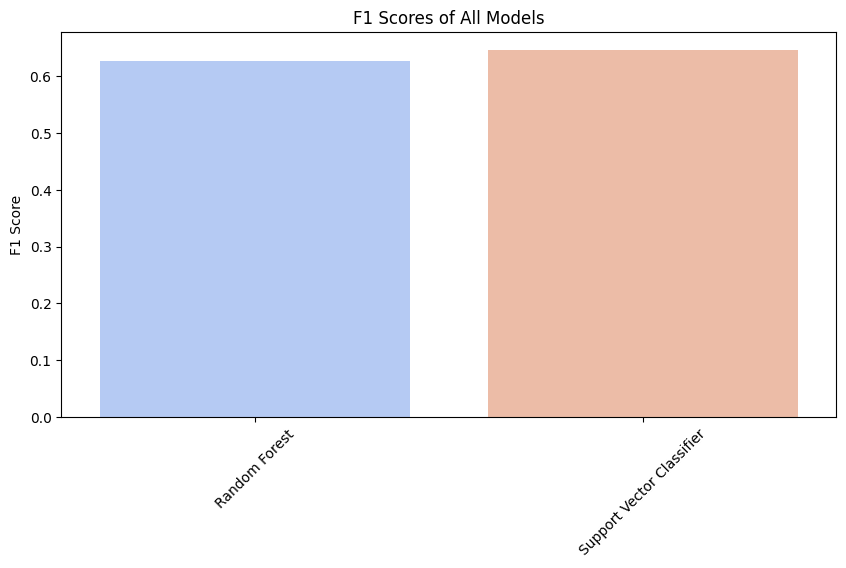

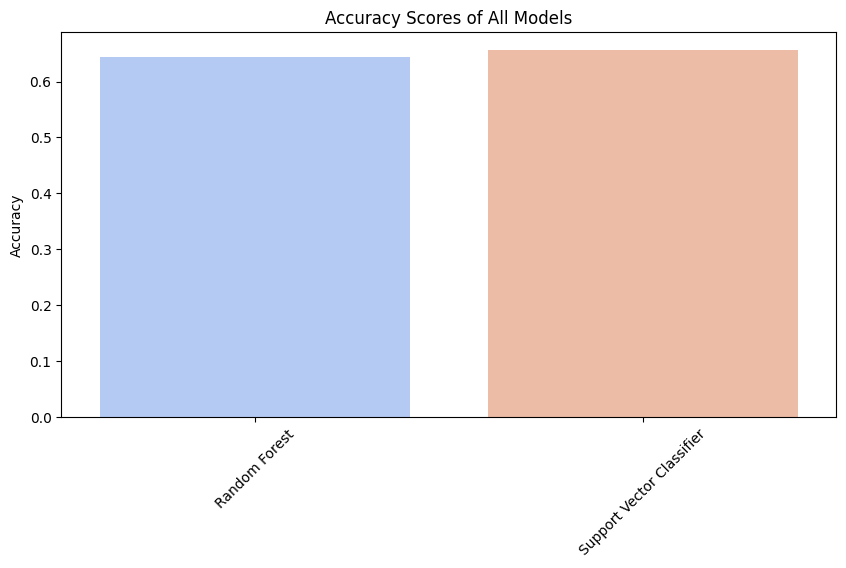

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Load and process the dataset
metabric_df = pd.read_csv("Downloads/METABRIC_RNA_Mutation.csv")
print("Dataset shape:", metabric_df.shape)

# Display the info of only relevant columns (numeric columns)
print(metabric_df.select_dtypes(include=['int64', 'float64']).info())

# Display only a subset of rows for selected columns (to check the relevant columns)
print(metabric_df[['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type']].head())

# Set patient_id as the index and select expression data columns with the target column
metabric_df = metabric_df.set_index('patient_id')
df_expression = metabric_df.iloc[:, 30:519].join(metabric_df['overall_survival'], how='inner')

# Dictionary to store F1 and accuracy scores of each model
metrics_summary = {"Model": [], "F1 Score": [], "Accuracy": []}

# Function to evaluate and display results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    # Predictions and probabilities (if applicable)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    # Store the metrics
    metrics_summary["Model"].append(model_name)
    metrics_summary["F1 Score"].append(f1)
    metrics_summary["Accuracy"].append(accuracy)

    # Display classification metrics
    print(f"\n=== {model_name} ===")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # AUC-ROC Score (if applicable)
    if y_proba is not None:
        print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Main function to process the dataset and evaluate models
def main(df, target_column):
    # Prepare the dataset
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Handle categorical variables
    X = pd.get_dummies(X, drop_first=True)
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define classifiers to be evaluated
    models = {
        'Random Forest': RandomForestClassifier(),
        'Support Vector Classifier': SVC(probability=True),
    }

    # Train and evaluate all models
    for name, model in models.items():
        evaluate_model(model, X_train, X_test, y_train, y_test, name)

    # Plot F1 Scores of all models
    plt.figure(figsize=(10, 5))
    sns.barplot(x=metrics_summary["Model"], y=metrics_summary["F1 Score"], hue=metrics_summary["Model"], palette='coolwarm', dodge=False, legend=False)
    plt.xticks(rotation=45)
    plt.title('F1 Scores of All Models')
    plt.ylabel('F1 Score')
    plt.show()

    # Plot Accuracy Scores of all models
    plt.figure(figsize=(10, 5))
    sns.barplot(x=metrics_summary["Model"], y=metrics_summary["Accuracy"], hue=metrics_summary["Model"], palette='coolwarm', dodge=False, legend=False)
    plt.xticks(rotation=45)
    plt.title('Accuracy Scores of All Models')
    plt.ylabel('Accuracy')
    plt.show()

# Load your dataset and specify the target column
if __name__ == "__main__":
    # Use the dataframe created with selected expression columns and target
    df = df_expression  # Example input dataframe
    target_column = 'overall_survival'  # Replace with the actual target column name in your dataset
    main(df, target_column)
